In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [184]:
path = './traces/'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T_*_N_20k-*.prof.h5")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces/dpotrf_T_800_N_20k-1.prof.h5
./traces/dpotrf_T_800_N_20k-0.prof.h5
./traces/dpotrf_T_200_N_20k-1.prof.h5
./traces/dpotrf_T_200_N_20k-0.prof.h5
./traces/dpotrf_T_400_N_20k-0.prof.h5
./traces/dpotrf_T_400_N_20k-1.prof.h5


In [185]:
print(len(li))

6


# Clean the data

In [186]:
for i in range(0, len(li)):
    li[i] = li[i][['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
    li[i]['exec_time'] = (li[i]['end'] - li[i]['begin']) * .001 #0.001 nano seconds to micro seconds
    li[i] = li[i].astype(float)

In [187]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [188]:
for i in range(0, len(li)):
    filter = ( (li[i]['task_class_id'] >= 0 ) & ( li[i]['task_class_id'] <= 3 ) & ( li[i]['priority'] >= 0 ) )
    #remove all other classes other than dpotrf, dgemm, trsm and syrk
    li[i] = li[i][filter]
    li[i].head()

## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [189]:
li[2][li[2]['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
99,1.001649e+09,1.002551e+09,4.0,3.0,0.0,3.0,960000.0,859697.0,902.193
102,1.003796e+09,1.004417e+09,4.0,3.0,0.0,3.0,960000.0,498115.0,621.305
103,1.004439e+09,1.005048e+09,4.0,3.0,0.0,3.0,960000.0,501367.0,608.873
104,1.195731e+09,1.196432e+09,4.0,3.0,0.0,3.0,960000.0,496063.0,700.883
105,1.196456e+09,1.197024e+09,4.0,3.0,0.0,3.0,960000.0,494107.0,568.231


## Load Models

In [190]:
new_LR_model = tf.keras.models.load_model('./LR_model_all_class')

In [191]:
new_DNN_model = tf.keras.models.load_model('./DNN_all_class')

In [219]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0

LR_predicted = new_LR_model.predict([1.0, 320000.0, 804357.0, 0, 1, 0, 0, 0])
DNN_predicted = new_DNN_model.predict([1.0, 320000.0, 1804357.0, 0, 1, 0, 0, 0])
Actual = '348.527'
print('Actual = ' + str(Actual) + ' LR_predicted ' + str(LR_predicted) + ' DNN_predicted ' + str(DNN_predicted))

filter = (li[2]['task_class_id'] == 0 )
df_0 = li[2][filter]
print('----------------- Class 0 -------------------------- ')
print('Min = ' + str(df_0['exec_time'].min()))
print('Max = ' + str(df_0['exec_time'].max()))
print('Avg = ' + str(sum(df_0['exec_time']) / len(df_0['exec_time'])))
print('Std = ' + str(df_0['exec_time'].std()))



Actual = 348.527 LR_predicted [[239.487]] DNN_predicted [[287.472]]
----------------- Class 0 -------------------------- 
Min = 278.095
Max = 24239.428
Avg = 473.7791866666665
Std = 1953.628900278608


In [220]:
df_0.shape[0]

150

In [221]:
Q1 = df_2['exec_time'].quantile(0.25)
Q3 = df_2['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
filter = (df_2['exec_time'] >= Q1 - 1.5 * IQR) & (df_2['exec_time'] <= Q3 + 1.5 *IQR)
df_2 = df_2.loc[filter]
df_2 = df_2.astype(float)

In [222]:
print('----------------- Class 0 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

----------------- Class 0 -------------------------- 
Min = 278.095
Max = 347.14300000000003
Avg = 309.9780857142857
Std = 12.77374295691325


In [223]:
df_2.shape[0]

140

In [175]:
print(df_2.shape[0])
d = 2 * df_2['exec_time'].min()
print(df_2[df_2['exec_time'] < d]['exec_time'].count())

150
142


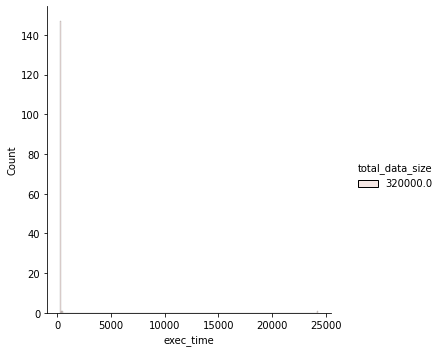

In [193]:
sns.displot(df_2, x="exec_time", hue='total_data_size', binwidth=100)

In [203]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0

LR_predicted = new_LR_model.predict([2.0, 640000.0, 128.0, 0, 0, 1, 0, 0])
DNN_predicted = new_DNN_model.predict([2.0, 640000.0, 128.0, 0, 0, 1, 0, 0])
Actual = '566.124'
print('Actual = ' + str(Actual) + ' LR_predicted ' + str(LR_predicted) + ' DNN_predicted ' + str(DNN_predicted))

filter = (li[2]['task_class_id'] == 1 )
df_2 = li[2][filter]
print('----------------- Class 1 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

Actual = 566.124 LR_predicted [[521.365]] DNN_predicted [[559.016]]
----------------- Class 1 -------------------------- 
Min = 238.573
Max = 152479.22400000002
Avg = 1276.7201241496618
Std = 5979.354687681714


In [204]:
df_2.shape[0]

14700

In [205]:
Q1 = df_2['exec_time'].quantile(0.25)
Q3 = df_2['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
filter = (df_2['exec_time'] >= Q1 - 1.5 * IQR) & (df_2['exec_time'] <= Q3 + 1.5 *IQR)
df_2 = df_2.loc[filter]
df_2 = df_2.astype(float)

In [207]:
print('----------------- Class 1 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

----------------- Class 1 -------------------------- 
Min = 238.573
Max = 987.001
Avg = 452.0867731705602
Std = 146.68064954906805


In [206]:
df_2.shape[0]

14253

In [177]:
print(df_2.shape[0])
d = 2 * df_2['exec_time'].min()
print(df_2[df_2['exec_time'] < d]['exec_time'].count())

14700
6688


In [208]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0

LR_predicted = new_LR_model.predict([2.0, 640000.0, 45.0, 0, 0, 0, 1, 0])
DNN_predicted = new_DNN_model.predict([2.0, 640000.0, 45.0, 0, 0, 0, 1, 0])
Actual = '410.847'
print('Actual = ' + str(Actual) + ' LR_predicted ' + str(LR_predicted) + ' DNN_predicted ' + str(DNN_predicted))

filter = (li[2]['task_class_id'] == 2 )
df_2 = li[2][filter]
print('----------------- Class 2 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

Actual = 410.847 LR_predicted [[460.452]] DNN_predicted [[420.474]]
----------------- Class 2 -------------------------- 
Min = 182.93800000000002
Max = 109926.806
Avg = 1155.8401147712414
Std = 5697.340110099745


In [209]:
df_2.shape[0]

7650

In [210]:
Q1 = df_2['exec_time'].quantile(0.25)
Q3 = df_2['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
filter = (df_2['exec_time'] >= Q1 - 1.5 * IQR) & (df_2['exec_time'] <= Q3 + 1.5 *IQR)
df_2 = df_2.loc[filter]
df_2 = df_2.astype(float)

In [211]:
print('----------------- Class 2 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

----------------- Class 2 -------------------------- 
Min = 347.009
Max = 555.693
Avg = 426.7649801966291
Std = 42.74894478968878


In [212]:
df_2.shape[0]

7120

In [179]:
print(df_2.shape[0])
d = sum(df_2['exec_time']) / len(df_2['exec_time'])
print(df_2[df_2['exec_time'] < d]['exec_time'].count())

7650
7285


In [213]:
# nb_data_items total_data_size priority cache_likelihood task_class_0.0 task_class_1.0 task_class_2.0 task_class_3.0

LR_predicted = new_LR_model.predict([3.0, 960000.0, 729588.0, 0, 0, 0, 0, 1])
DNN_predicted = new_DNN_model.predict([3.0, 960000.0, 729588.0, 0, 0, 0, 0, 1])
Actual = '582.046'
print('Actual = ' + str(Actual) + ' LR_predicted ' + str(LR_predicted) + ' DNN_predicted ' + str(DNN_predicted))

filter = (li[2]['task_class_id'] == 3 )
df_2 = li[2][filter]
print('----------------- Class 3 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))



Actual = 582.046 LR_predicted [[672.263]] DNN_predicted [[1106.801]]
----------------- Class 3 -------------------------- 
Min = 484.444
Max = 202825.411
Avg = 1789.8751550896923
Std = 7376.083249413018


In [214]:
df_2.shape[0]

242550

In [215]:
Q1 = df_2['exec_time'].quantile(0.25)
Q3 = df_2['exec_time'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range.
filter = (df_2['exec_time'] >= Q1 - 1.5 * IQR) & (df_2['exec_time'] <= Q3 + 1.5 *IQR)
df_2 = df_2.loc[filter]
df_2 = df_2.astype(float)

In [217]:
df_2.shape[0]

227315

In [216]:
print('----------------- Class 3 -------------------------- ')
print('Min = ' + str(df_2['exec_time'].min()))
print('Max = ' + str(df_2['exec_time'].max()))
print('Avg = ' + str(sum(df_2['exec_time']) / len(df_2['exec_time'])))
print('Std = ' + str(df_2['exec_time'].std()))

----------------- Class 3 -------------------------- 
Min = 484.444
Max = 725.594
Avg = 589.538922785566
Std = 44.93857101013236


<AxesSubplot:>

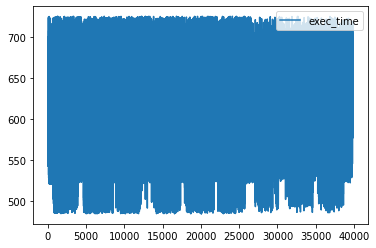

In [218]:
df_2.plot(y='exec_time', use_index=True)

In [181]:
print(df_2.shape[0])
d = sum(df_2['exec_time']) / len(df_2['exec_time'])
print(df_2[df_2['exec_time'] < d]['exec_time'].count())

242550
227160
